# Evaluation different transforms on spechum, temp, vorticity 60km -> 2.2km-4x over Birmingham

Compare original STV IPTS with one that has removed the scaling that assumes data is [0,1] or [-1,1] and:

* ISpatTLog
* IStanTSqrt

## Diff model

8-channels loc-spec params

Inputs: 5 levels of spechum, temp and vorticity

Target domain and resolution: 64x64 2.2km-4x England and Wales

Input resolution: 60km/gcmx

Input transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max

Sample inverse transform: multiply by saved train set max, clip negative values to 0 then square

Input transforms are fitted on dataset in use (ie separate GCM and CPM versions) while target transform is fitted only at training on the CPM dataset

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, plot_grid, prep_eval_data, show_samples, distribution_figure, plot_mean_bias, plot_std, plot_psd

In [2]:
split = "val"

In [3]:
datasets = {
    "CPM": "bham_gcmx-4x_spechum-temp-vort_random",
    "GCM": "bham_60km-4x_spechum-temp-vort_random",
}

runs = [
    ("bham-4x_STV_random-ls8-IPTS", "checkpoint-20", "STV"),
    ("bham-4x-STV_random-ls8-no-scalers", "checkpoint-20", "STV No scalers"),
    # ("bham-4x-STV_random-ls8-epoch-train", "epoch-100", "STV epoch training"),
    ("bham-4x_STV_random-ls8-ISpatTLog", "checkpoint-20", "STV Spat;Log"),
    # ("bham-4x_STV_random-ls8-ISpatTLog", "checkpoint-4", "STV Stan;Log"),
    ("bham-4x_STV_random-ls8-IStanTSqrt", "checkpoint-20", "STV Stan;Sqrt"),
    # ("bham-4x_STV_random-ls8-ISpatTLog", "checkpoint-4", "STV Spat;Sqrt")
]
stv_ds = prep_eval_data(datasets, runs, split)

In [4]:
merged_ds = xr.merge([stv_ds.drop_vars("pressure")])
merged_ds

<xarray.Dataset>
Dimensions:                     (time: 4320, grid_latitude: 64,
                                 grid_longitude: 64, model: 3, source: 2,
                                 sample_id: 3, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-03 12:00:00 ... 2080-11...
  * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
  * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
  * model                       (model) object 'STV' ... 'STV Stan;Sqrt'
    season                      (time) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * source                      (source) object 'CPM' 'GCM'
Dimensions without coordinates: sample_id, bnds
Data variables: (12/21)
    rotated_latitude_longitude  (source, model, sample_id, time) float64 -2.1...
    time_bnds                   (source, model, sample_id, time, bnds) object ...
    grid_latitude_bnds          (source, model, sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (source, model, sample_id, time, grid_longitude, bnds) float32 ...
    pred_pr                     (source, model, sample_id, time, grid_latitude, grid_longitude) float32 ...
    spechum250                  (source, time, grid_latitude, grid_longitude) float32 ...
    ...                          ...
    temp925                     (source, time, grid_latitude, grid_longitude) float32 ...
    vorticity250                (source, time, grid_latitude, grid_longitude) float64 ...
    vorticity500                (source, time, grid_latitude, grid_longitude) float64 ...
    vorticity700                (source, time, grid_latitude, grid_longitude) float64 ...
    vorticity850                (source, time, grid_latitude, grid_longitude) float64 ...
    vorticity925                (source, time, grid_latitude, grid_longitude) float64 ...

In [5]:
total_target_pr = merged_ds["target_pr"].sel(source="CPM").mean(dim=["grid_longitude", "grid_latitude"])

## Samples

CPM

DJF

very varied

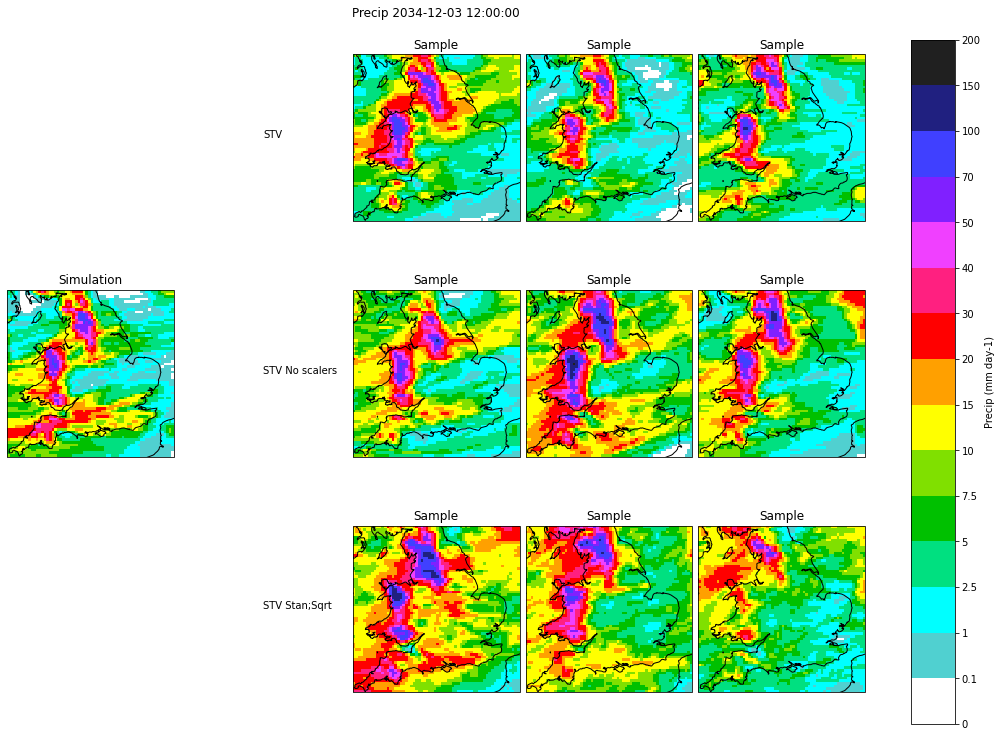

quiet wet

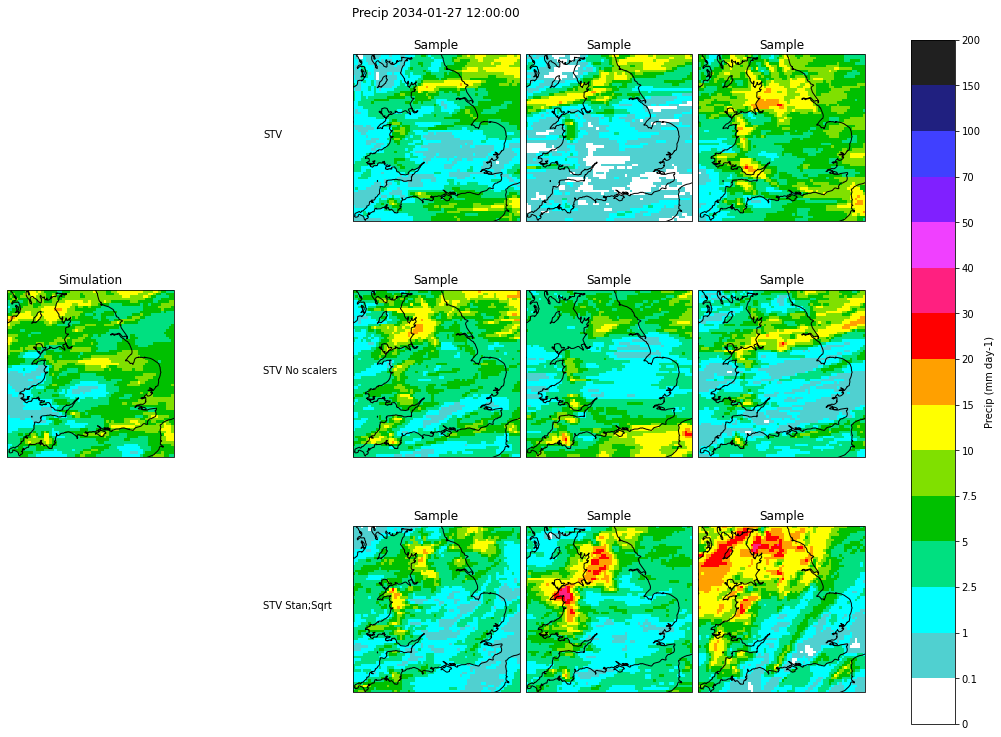

very dry

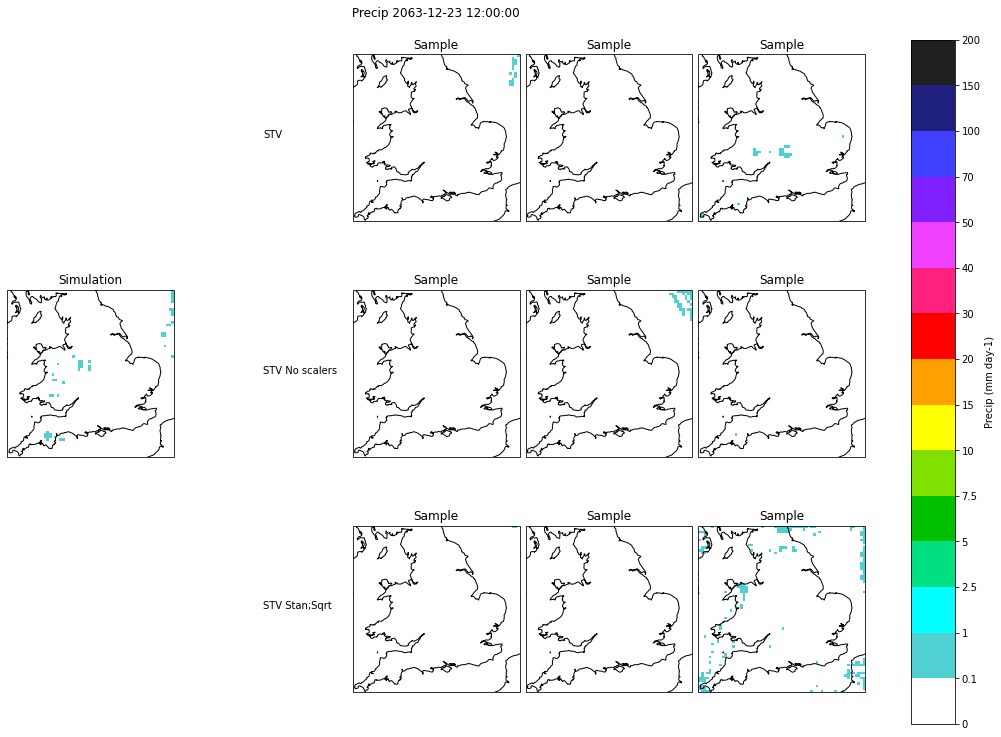

JJA

very varied

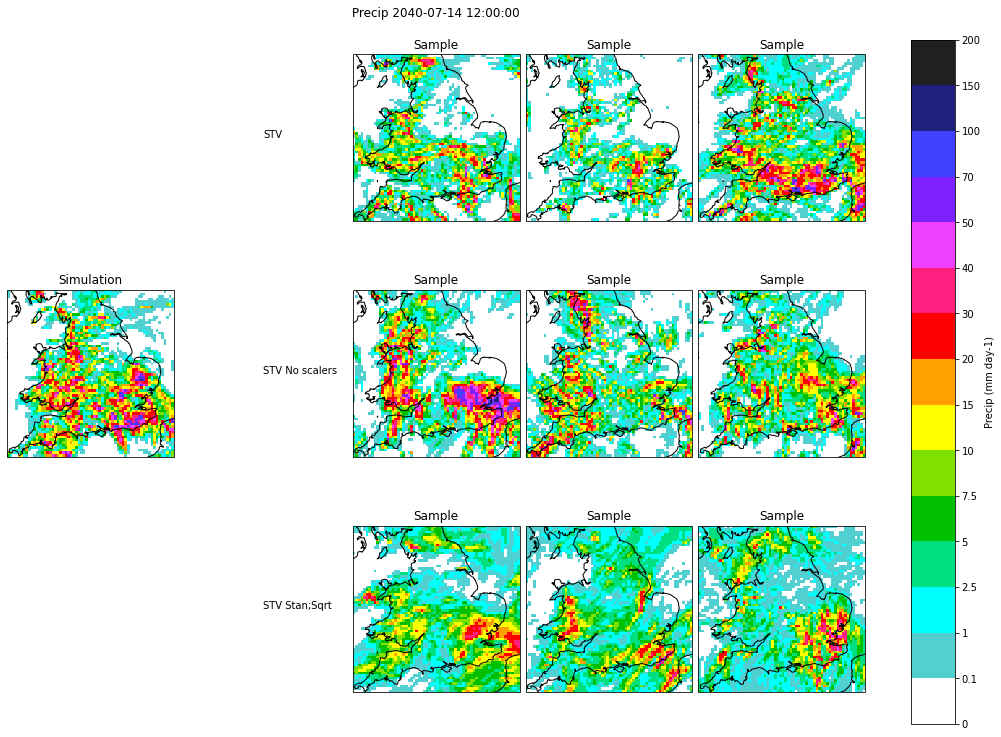

quiet wet

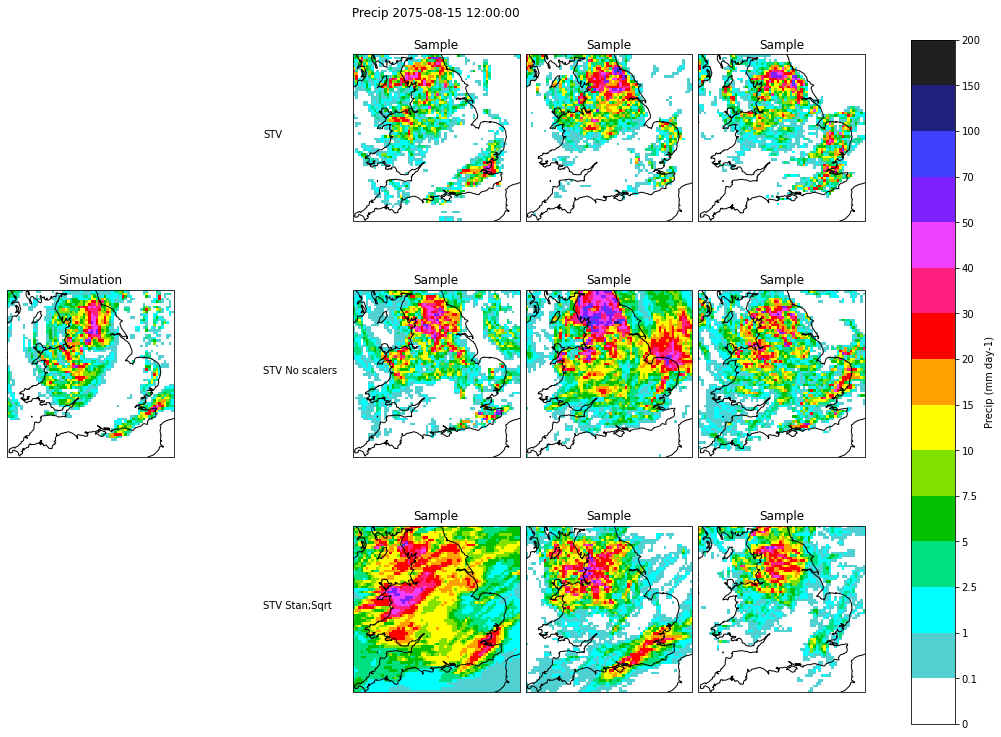

very dry

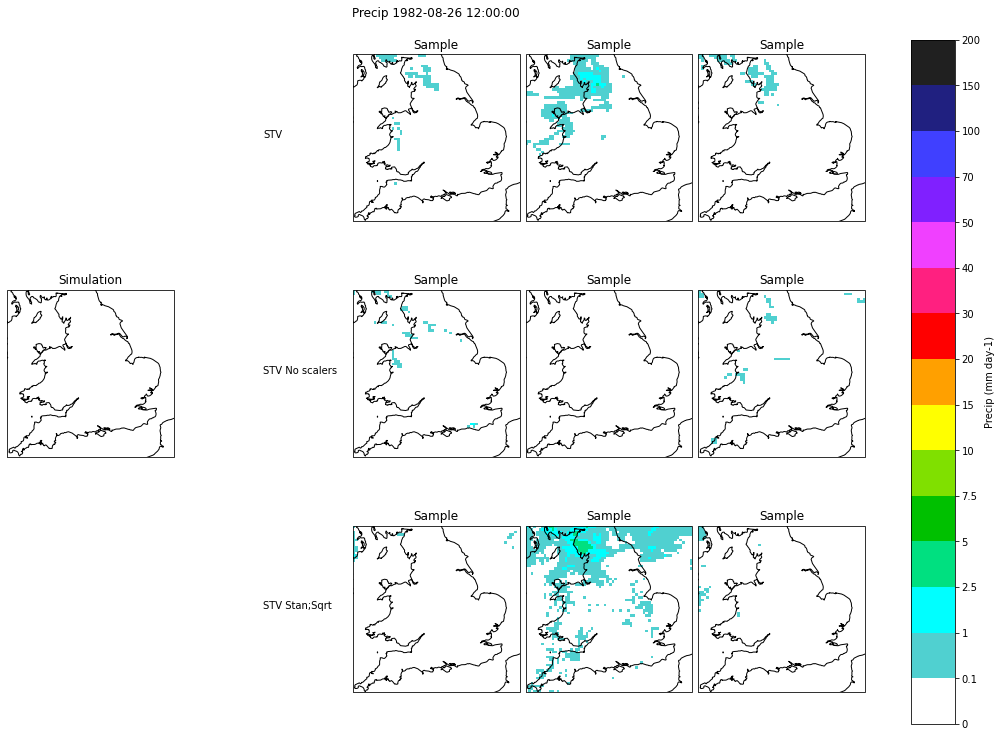

MAM

very varied

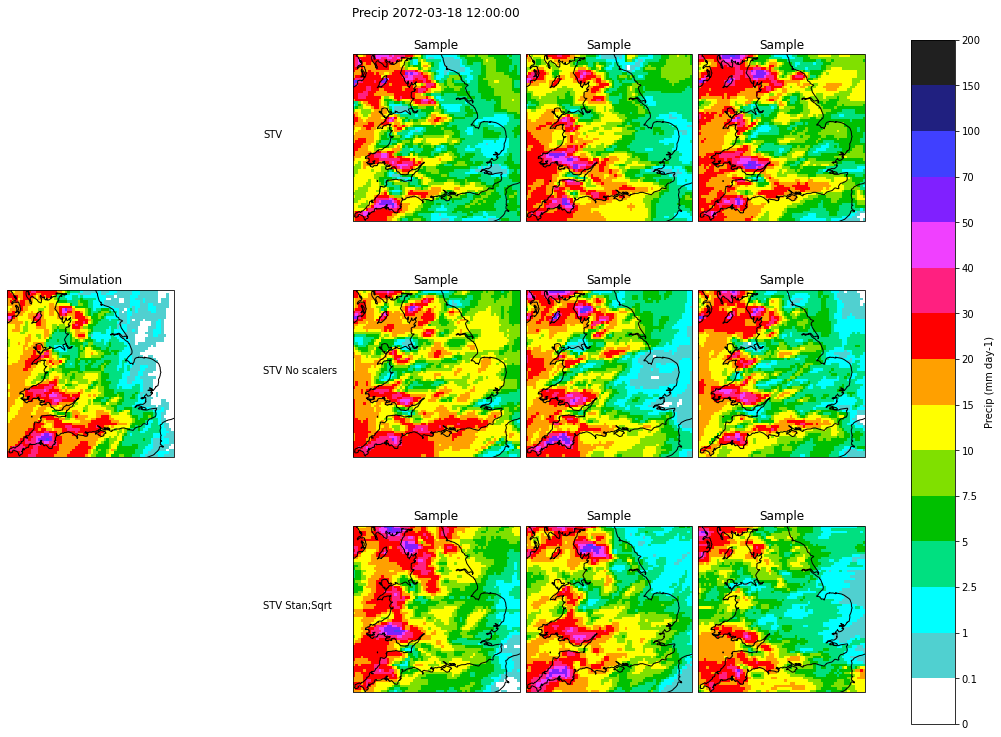

quiet wet

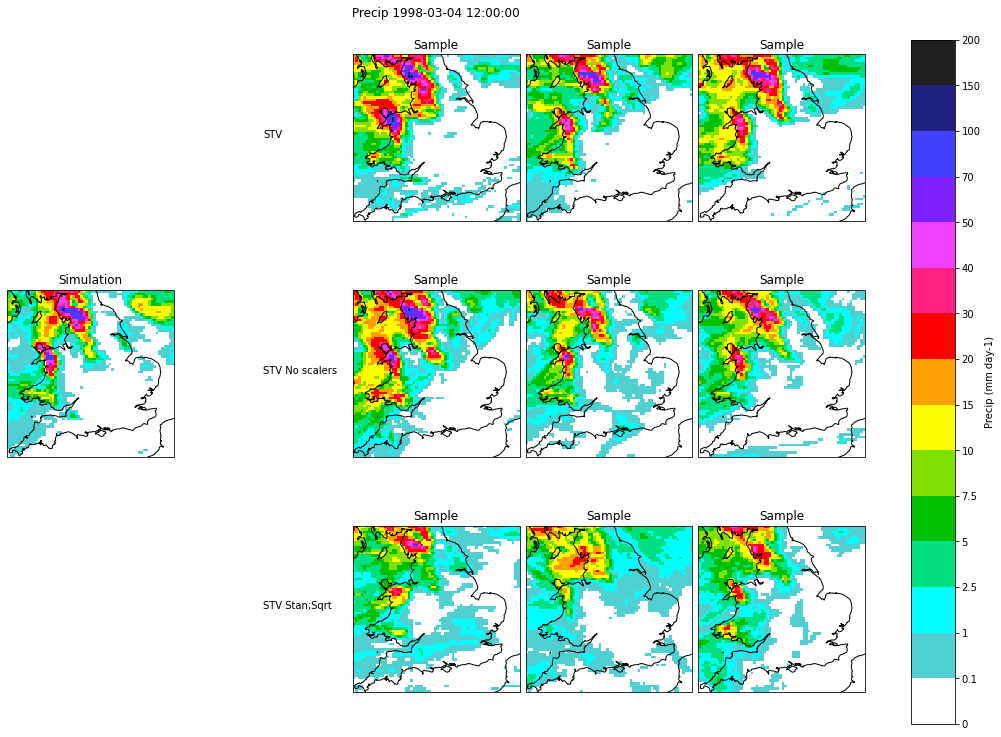

very dry

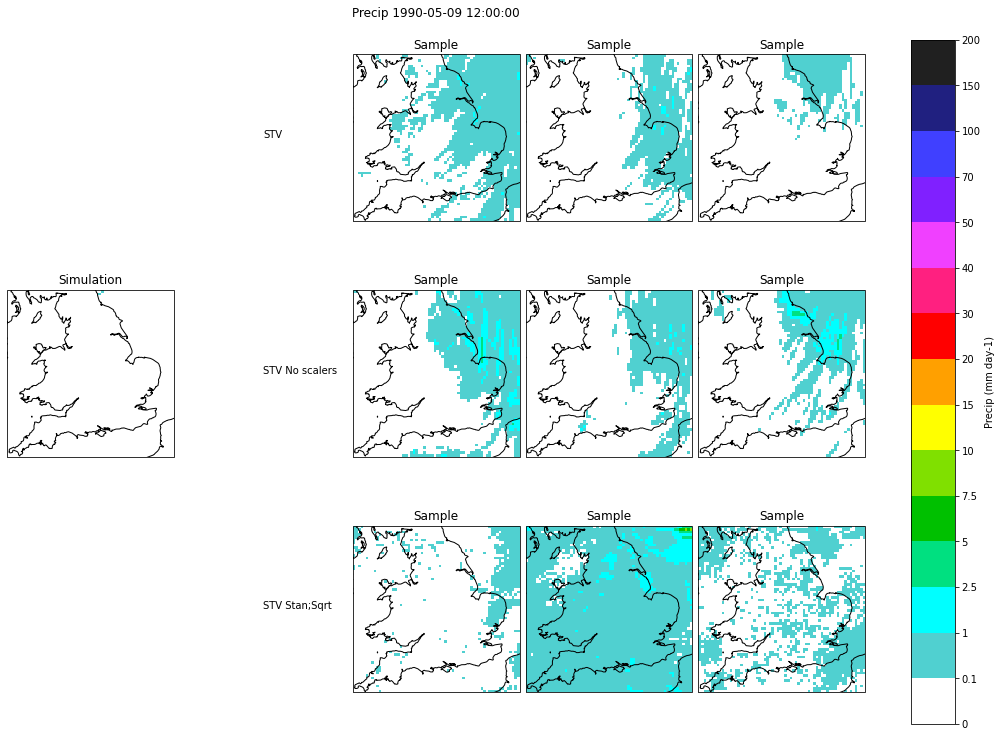

SON

very varied

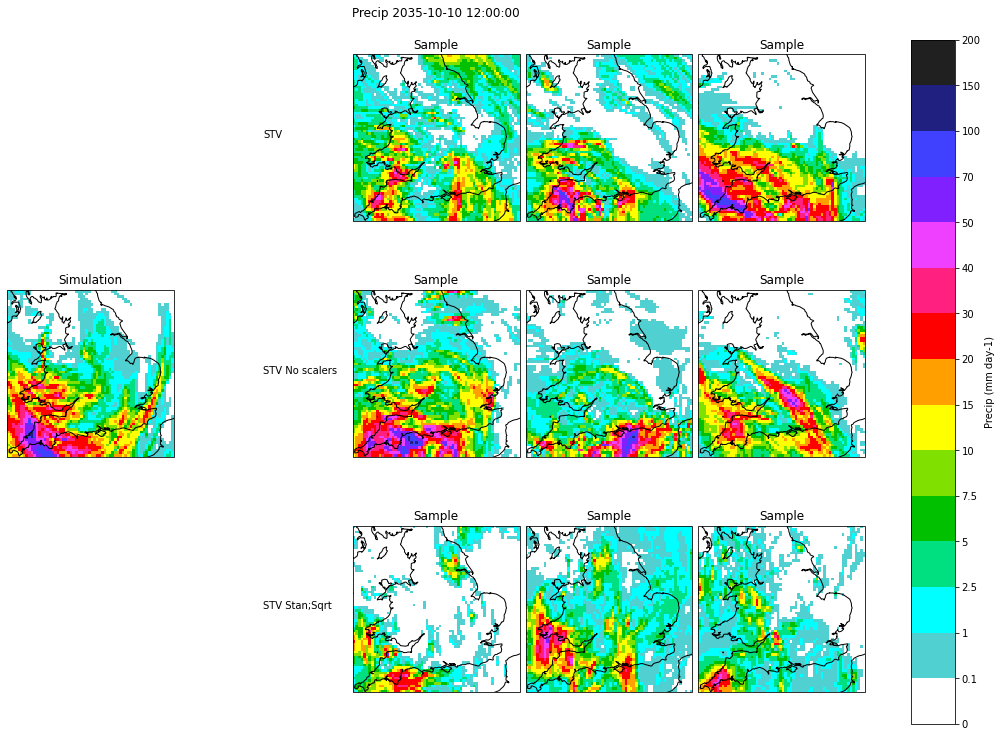

quiet wet

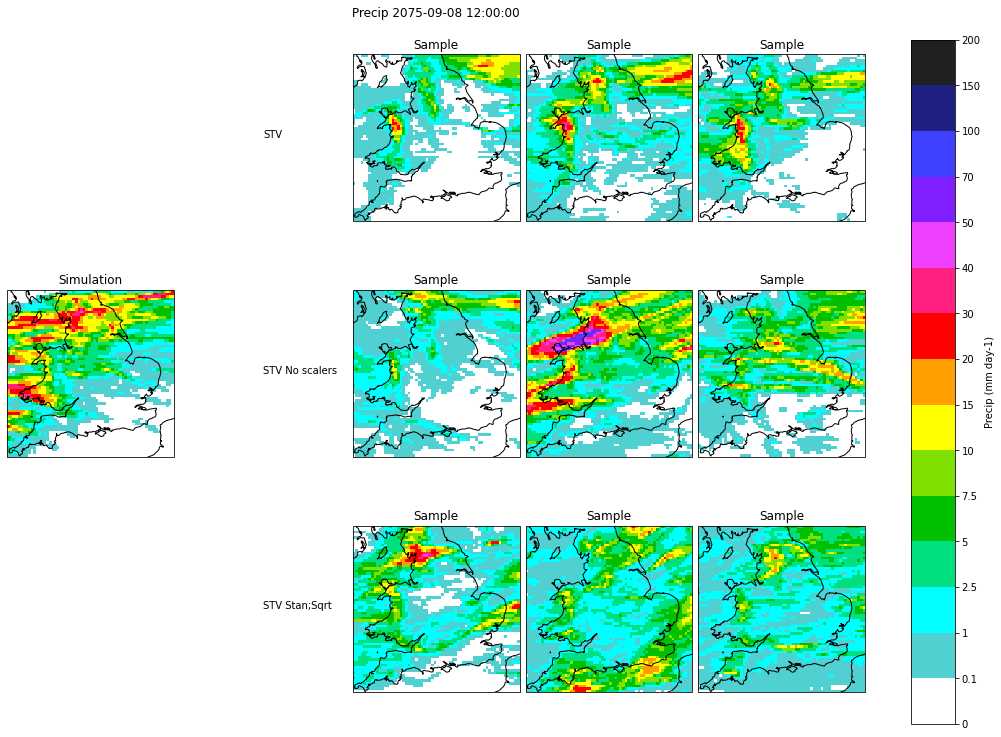

very dry

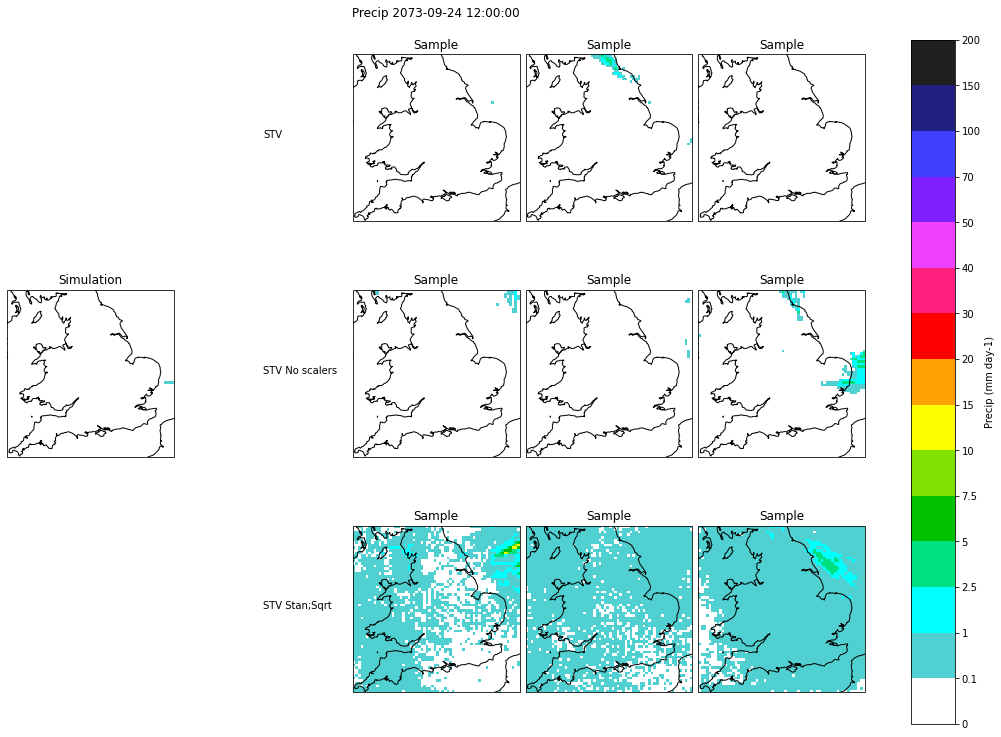

GCM

DJF

very varied

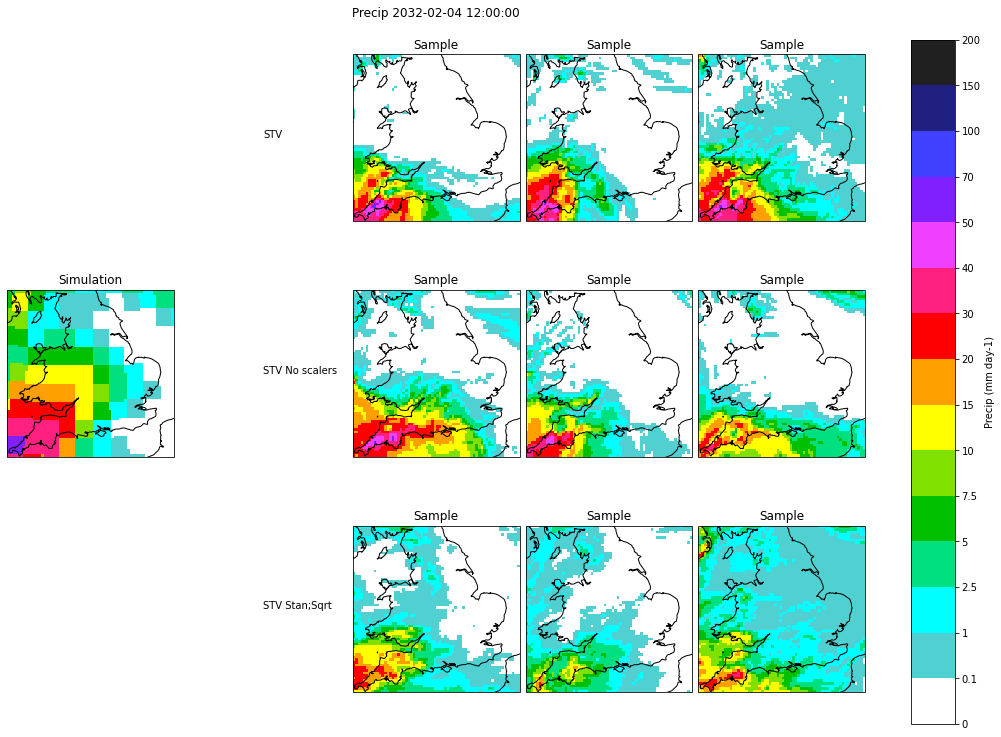

quiet wet

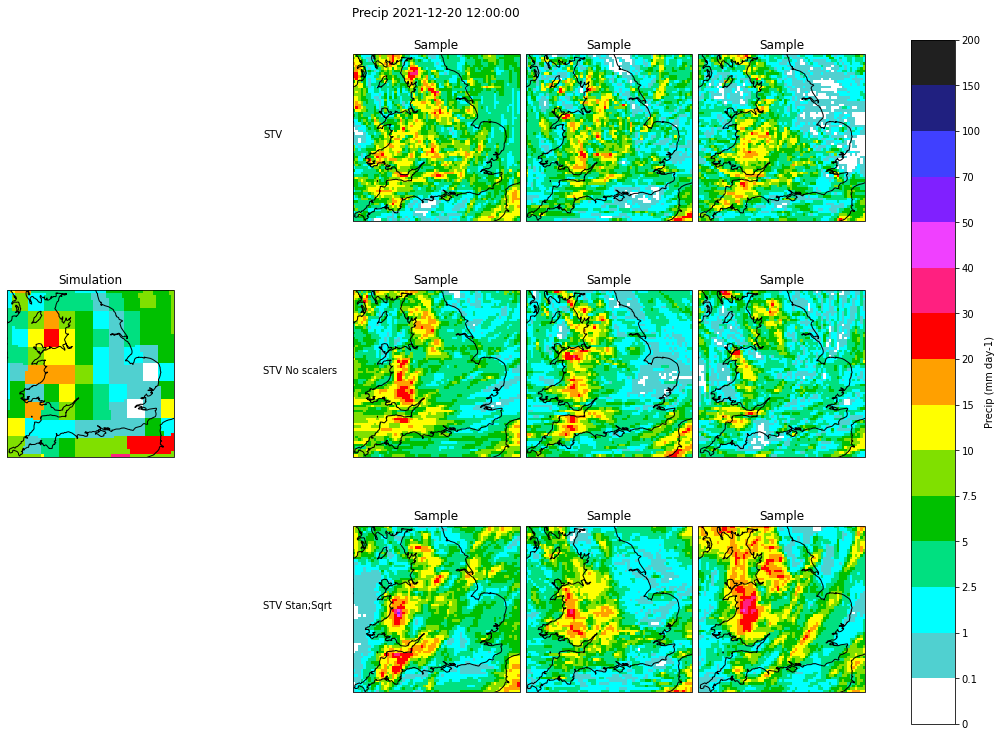

very dry

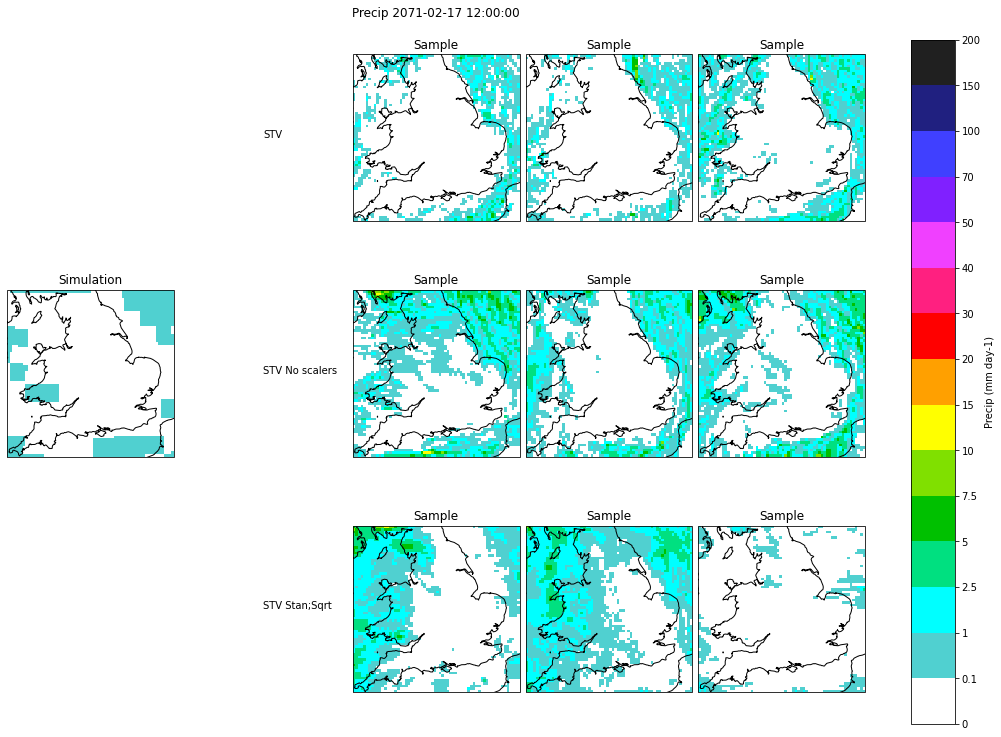

JJA

very varied

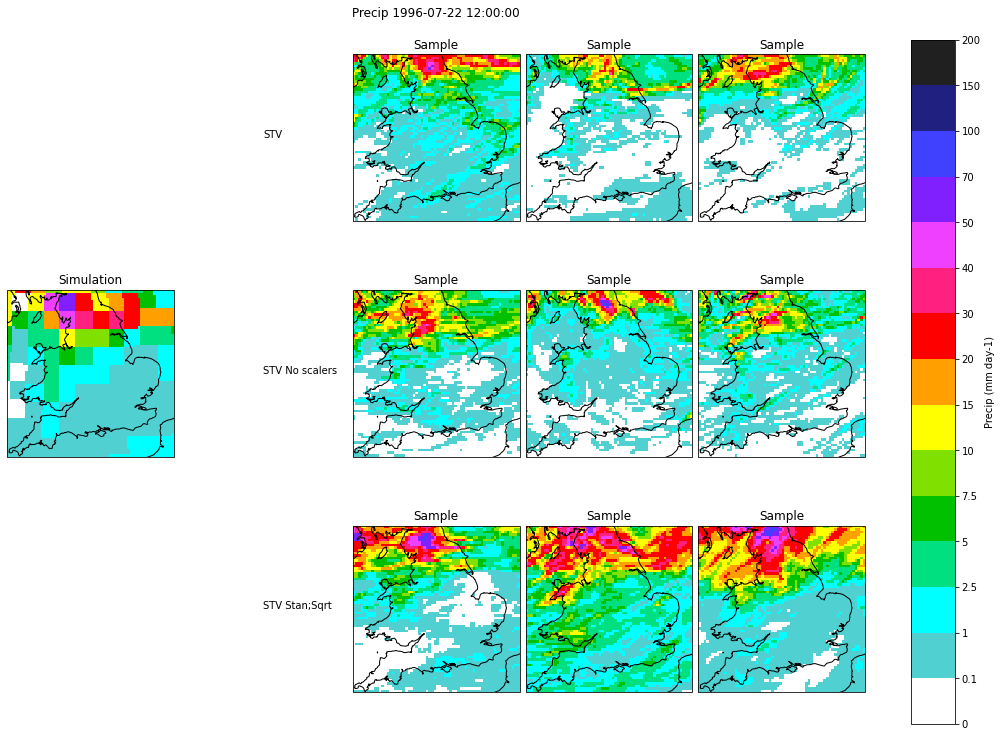

quiet wet

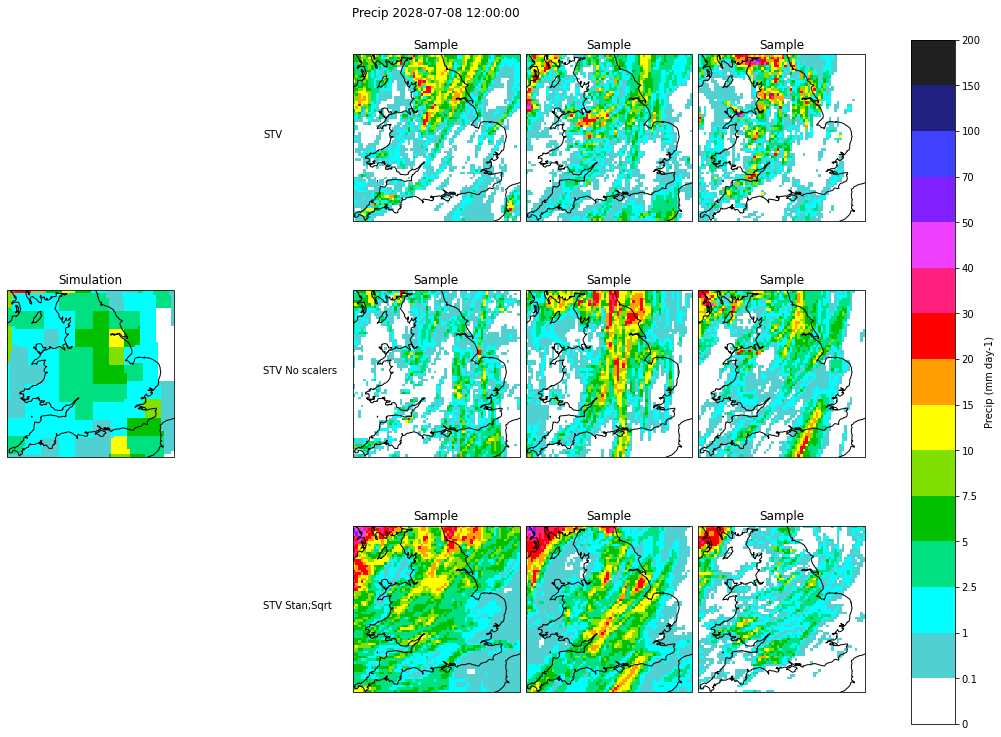

very dry

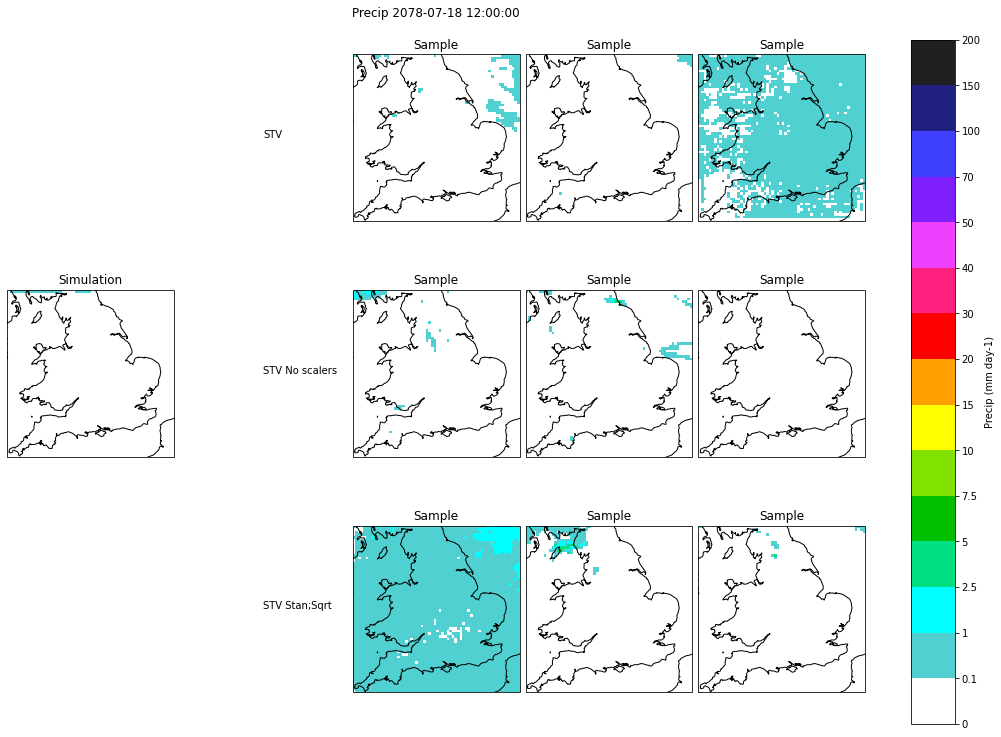

MAM

very varied

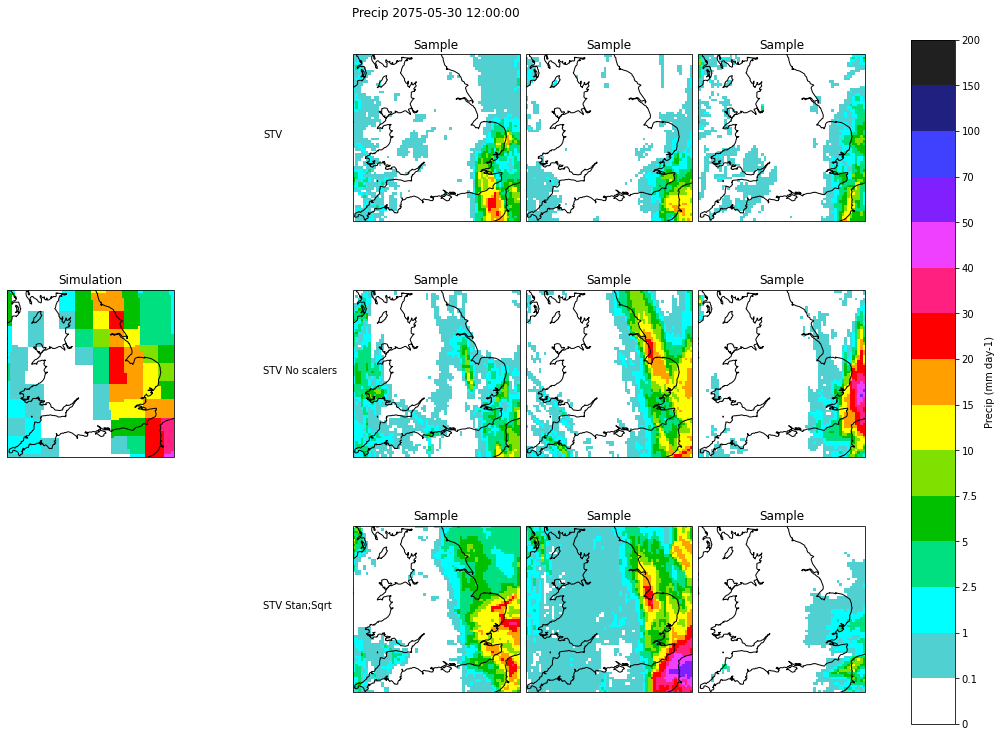

quiet wet

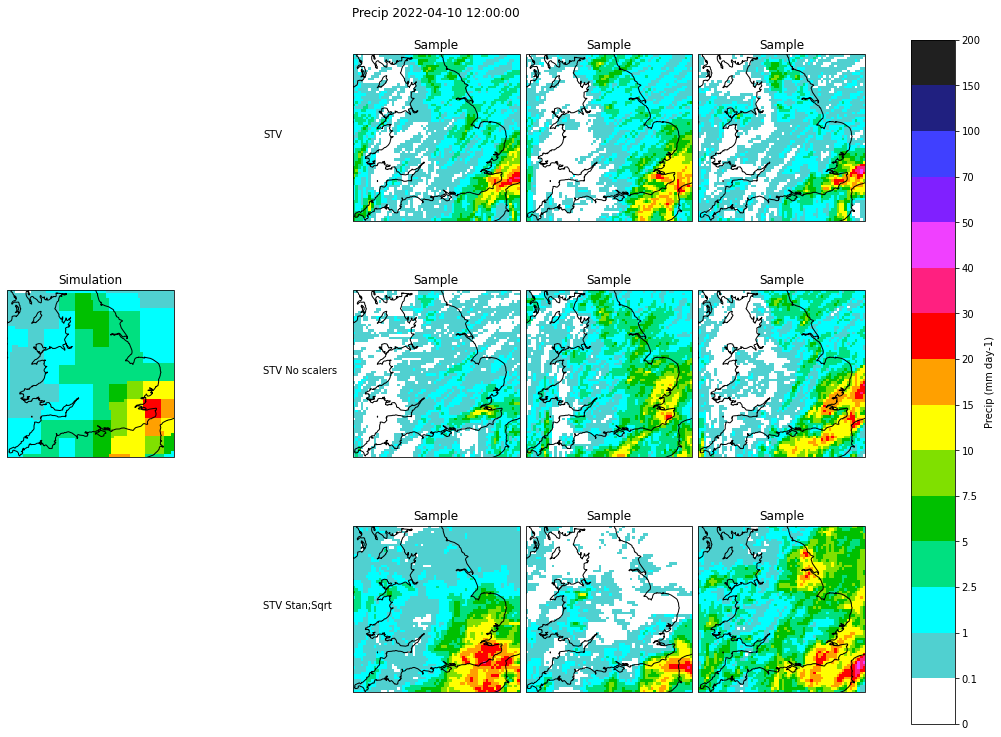

very dry

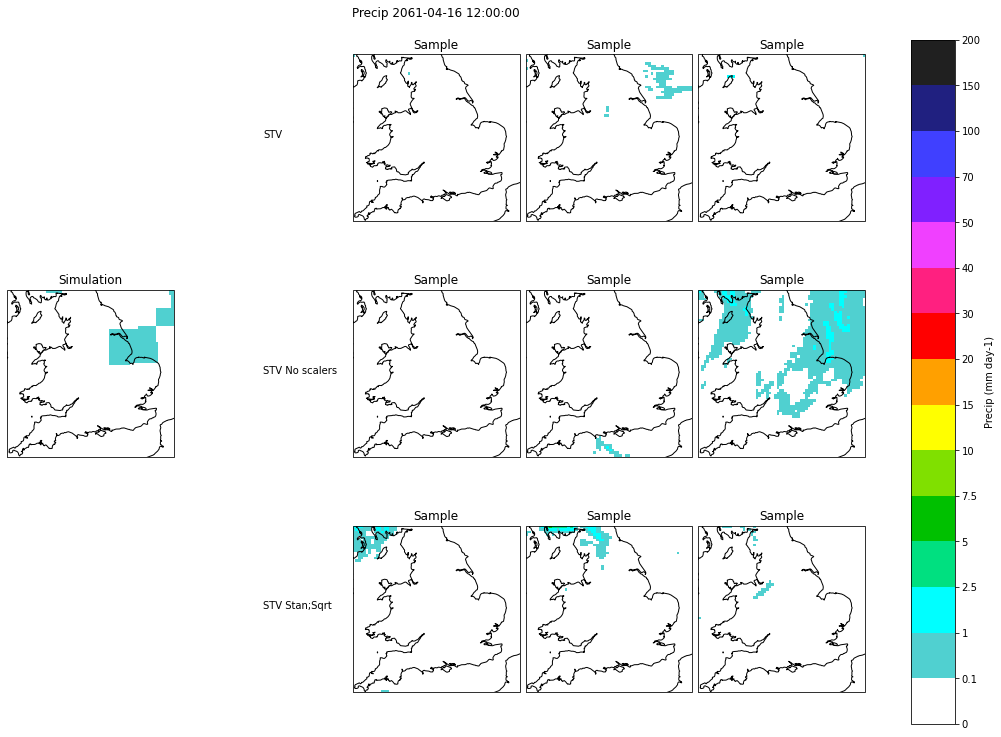

SON

very varied

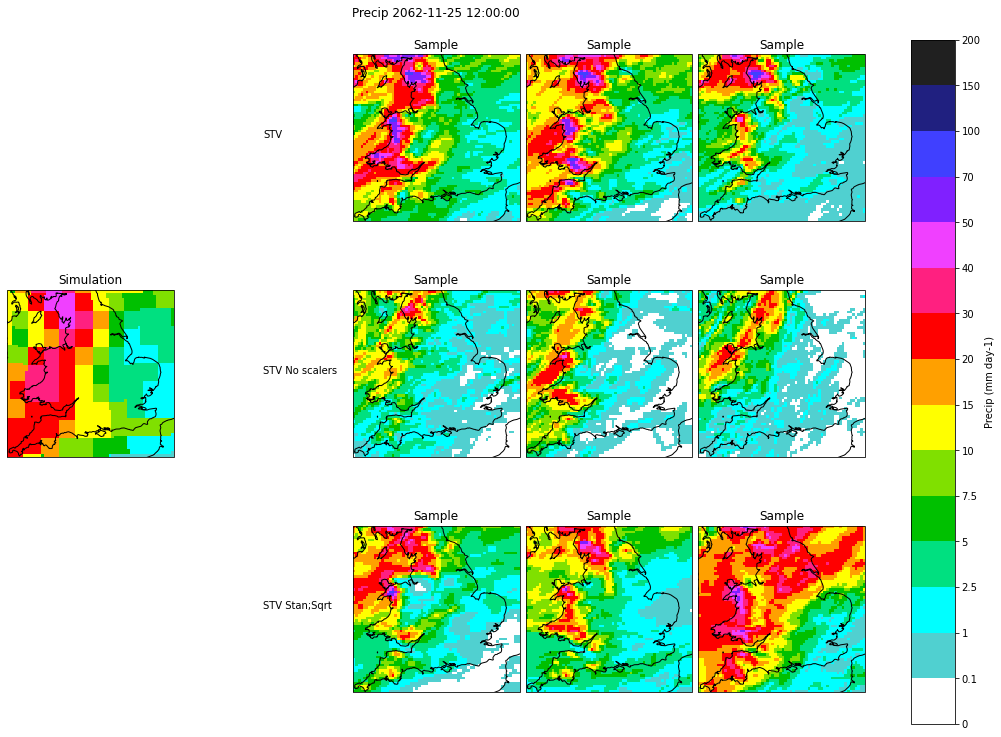

quiet wet

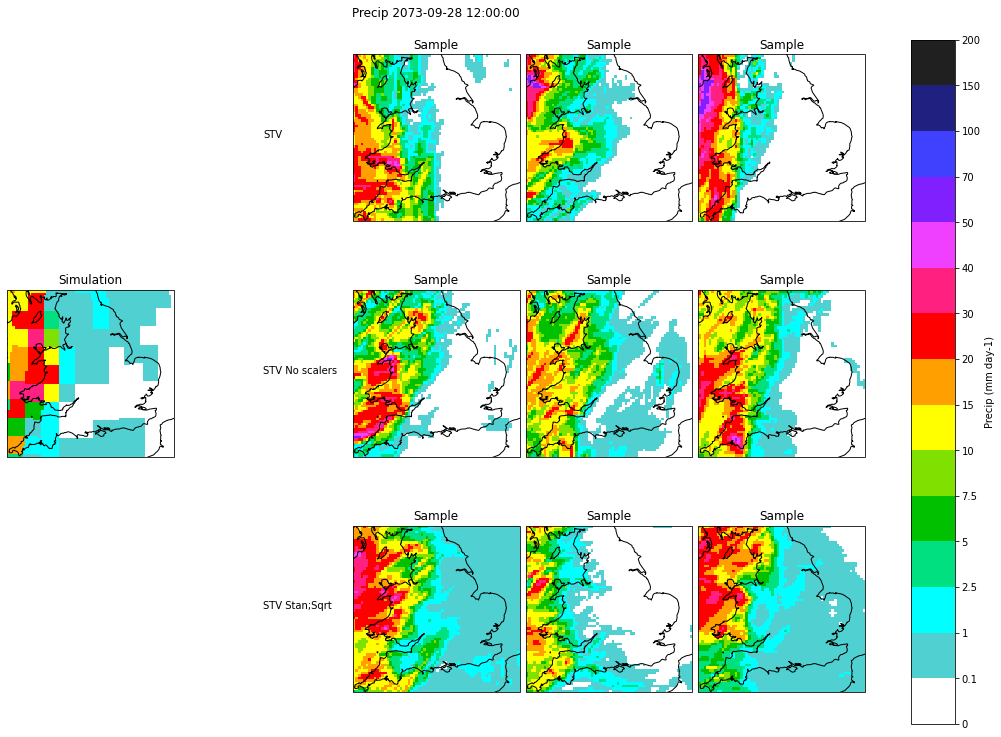

very dry

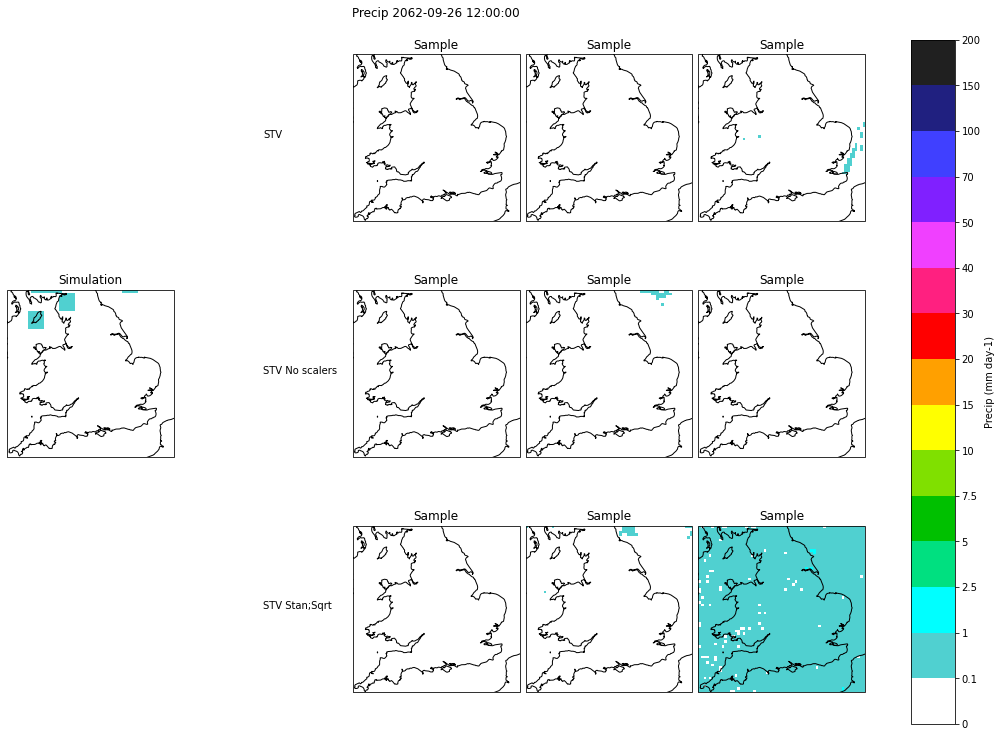

In [6]:
for source, sourced_ds in merged_ds.groupby("source"):
    IPython.display.display_html(f"<h1>{source}</h1>", raw=True)
    for season, seasonal_ds in sourced_ds.groupby("time.season"):
        IPython.display.display_html(f"<h2>{season}</h2>", raw=True)

        std = seasonal_ds["target_pr"].std(dim=["grid_longitude", "grid_latitude"])#/merged_ds.sel(source="CPM")["target_pr"].mean(dim=["grid_longitude", "grid_latitude"])
        std_sorted_time = std.sortby(-std)["time"].values
        mean = seasonal_ds["target_pr"].mean(dim=["grid_longitude", "grid_latitude"])
        mean_sorted_time = mean.sortby(-mean)["time"].values

        timestamp_chunks = {
            # "very wet": mean_sorted_time[20],
            "very varied": std_sorted_time[20],
            "quiet wet": mean_sorted_time[math.ceil(len(mean_sorted_time)*0.20)],
            # "quiet varied": std_sorted_time[math.ceil(len(std_sorted_time)*0.20):math.ceil(len(std_sorted_time)*0.20)+1],
            "very dry": mean_sorted_time[-20],
        }

        for desc, timestamps in timestamp_chunks.items():
            IPython.display.display_html(f"<h3>{desc}</h3>", raw=True)
            show_samples(seasonal_ds, [timestamps])

## Frequency distribution

### Pixel

CPM

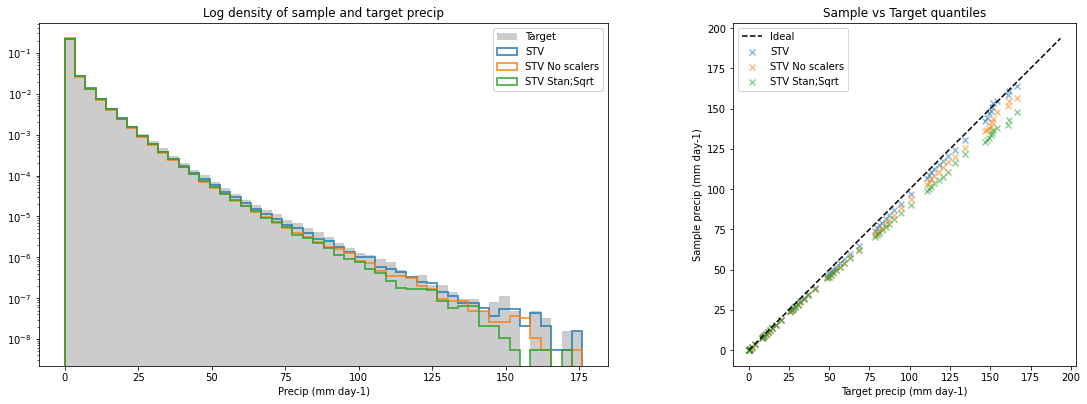

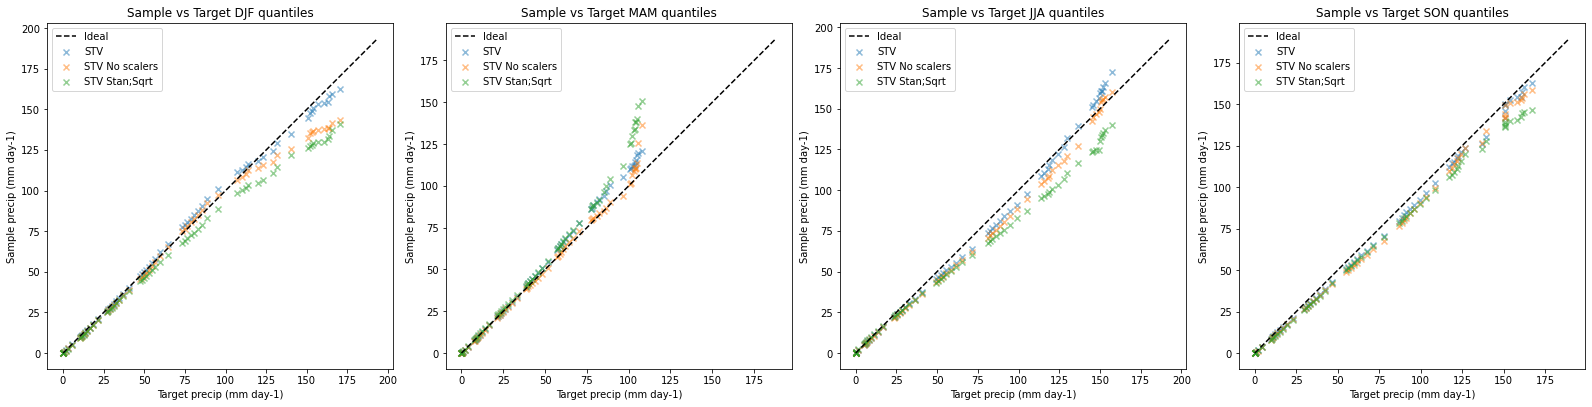

GCM

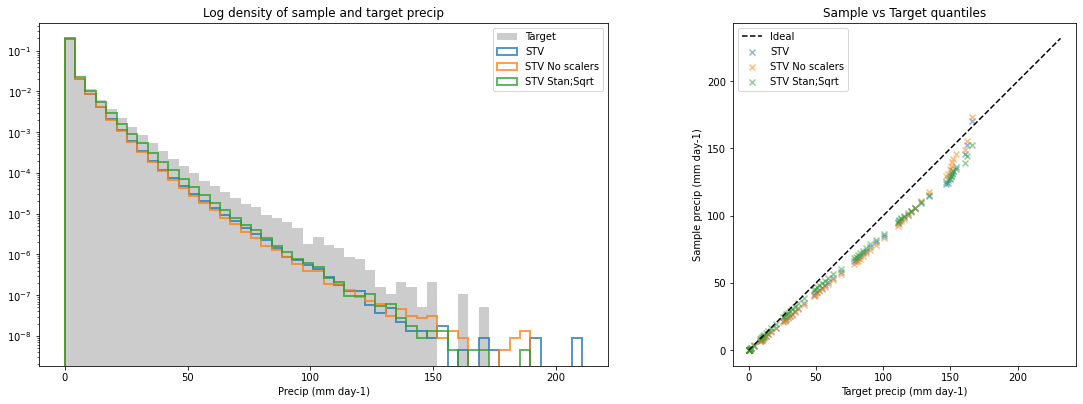

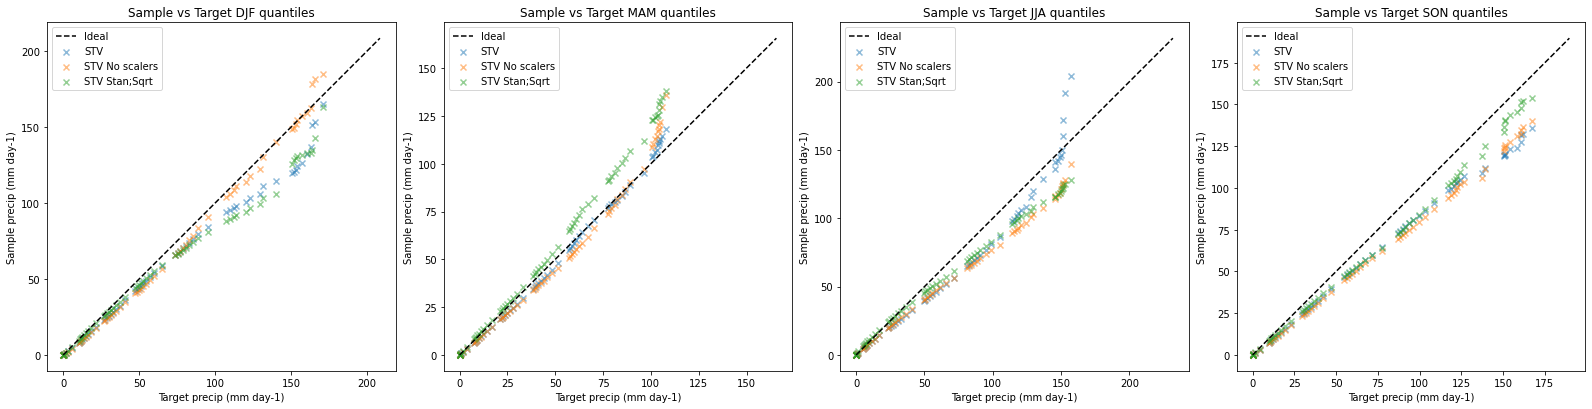

In [7]:
# quantiles = np.concatenate([np.linspace(0.1,0.9,9), np.linspace(0.91,0.99,9), np.linspace(0.991,0.999,9), 0.9999999])
quantiles = np.concatenate([np.linspace((1-10**(i+1))+(10**i), (1-10**i), 9) for i in range(-1, -8, -1)])

distribution_figure(merged_ds, quantiles, "Distribution of pixel values")

### Mean over space

CPM

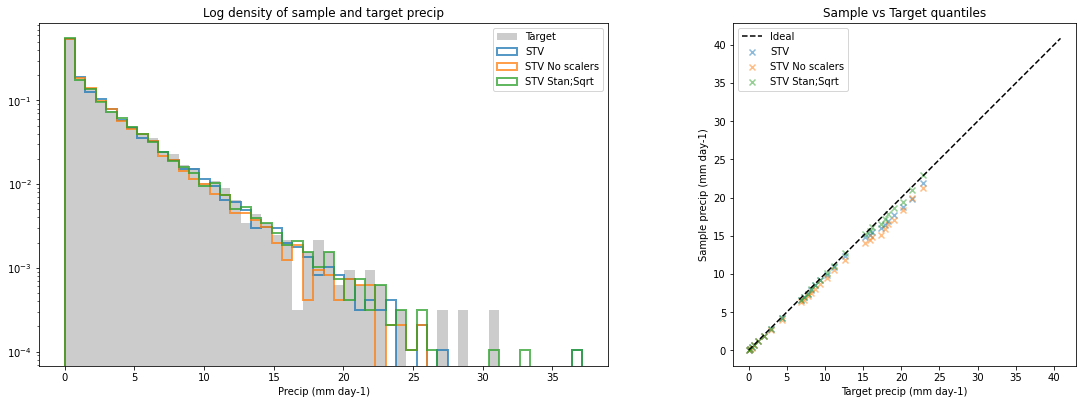

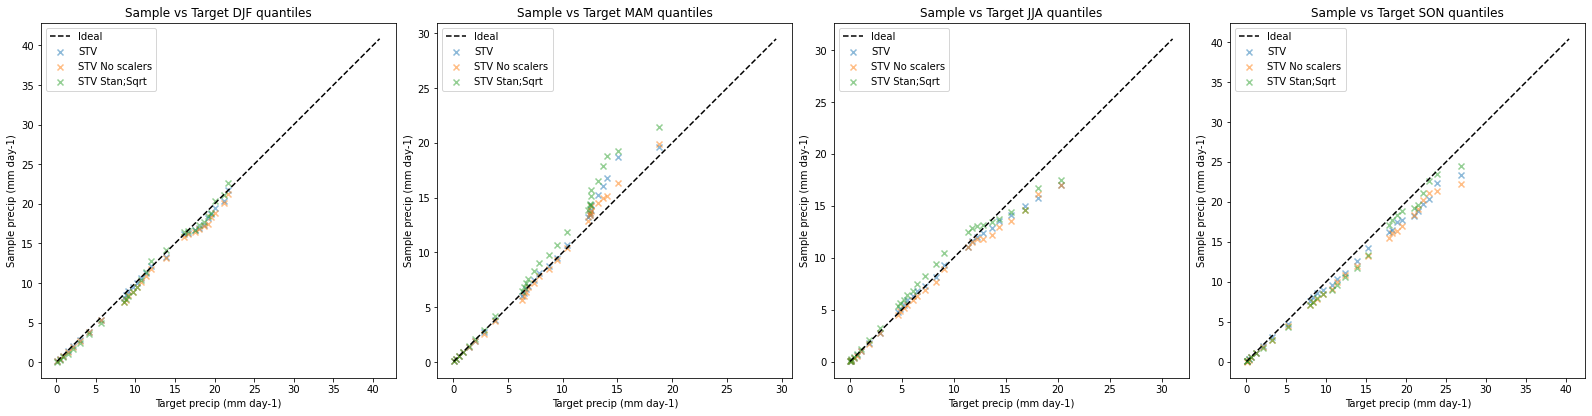

GCM

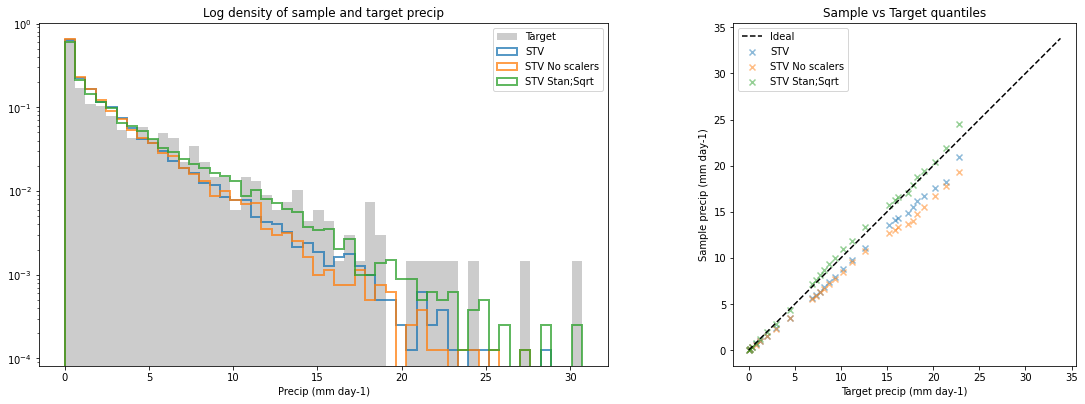

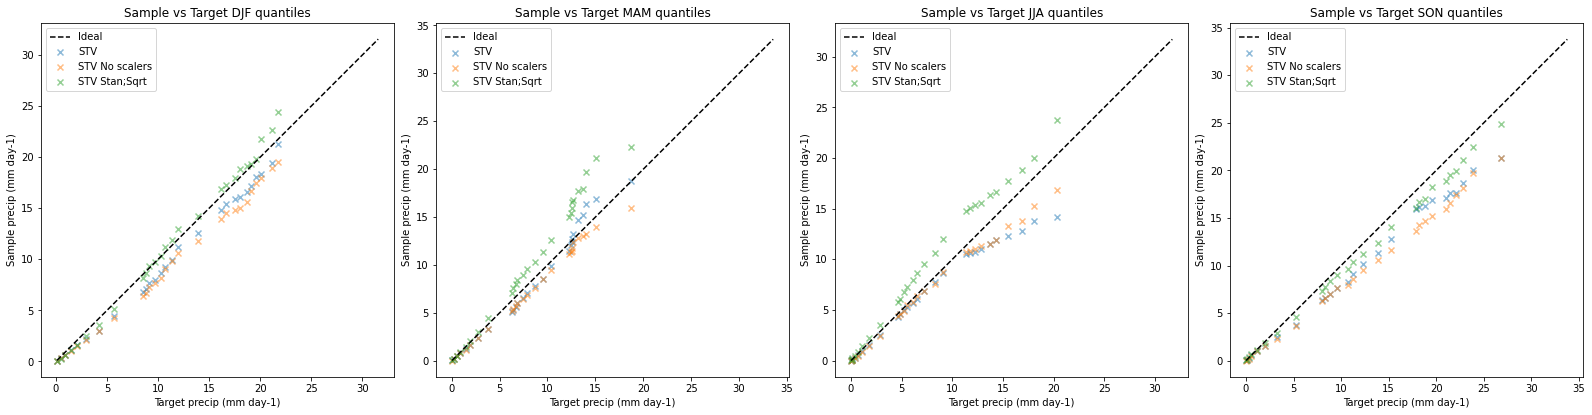

In [8]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.99,10), np.linspace(0.991,0.999,9)])

distribution_figure(merged_ds[["target_pr", "pred_pr"]].mean(dim=["grid_longitude", "grid_latitude"]), quantiles, "Distribution of mean precip over space")

## Bias

Bias/Target mean

All

CPM

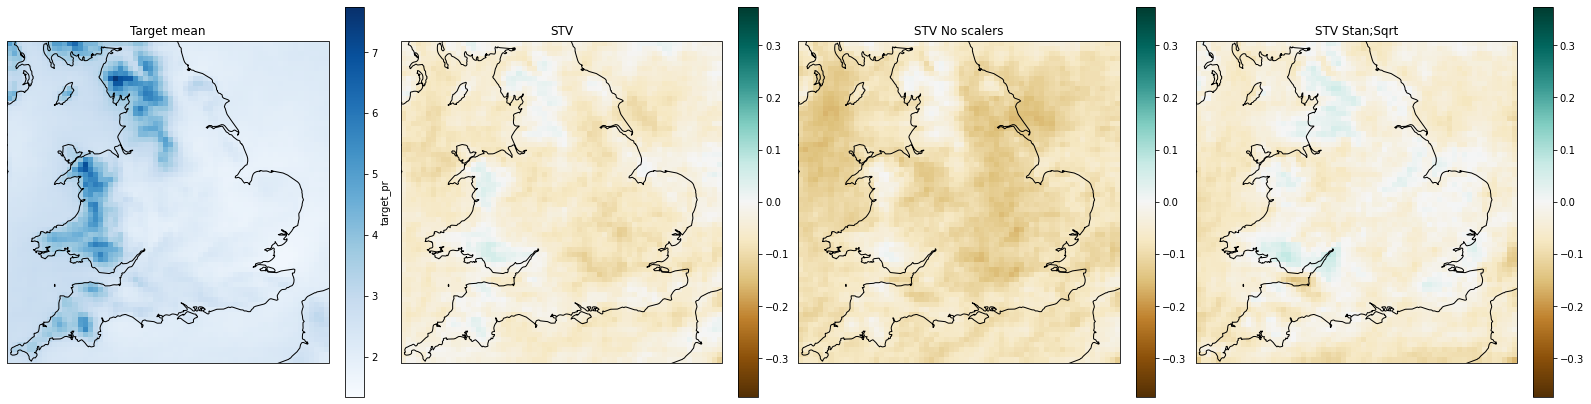

GCM

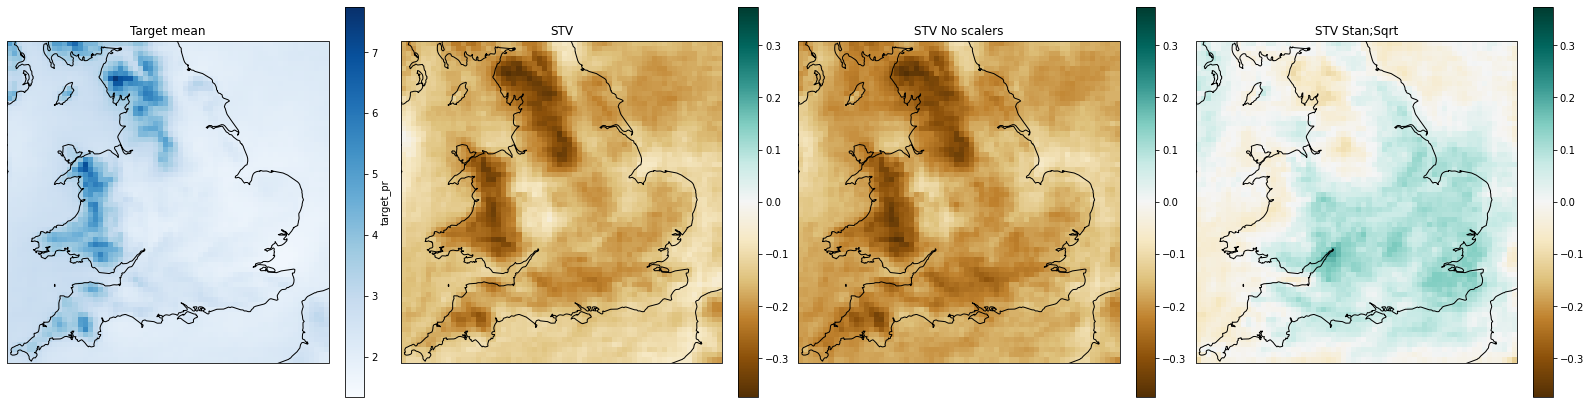

Season DJF

CPM

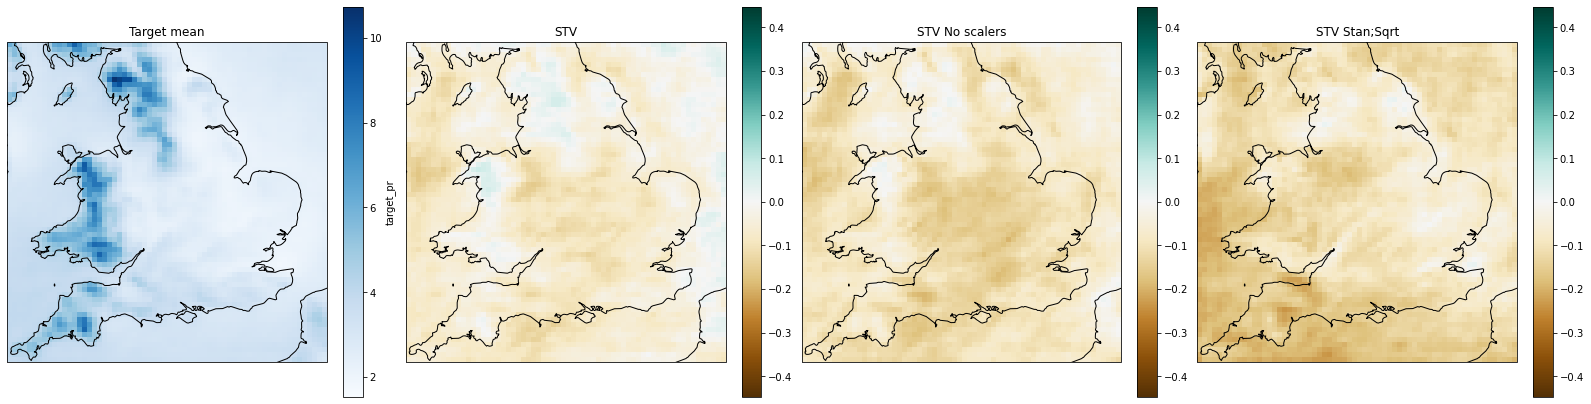

GCM

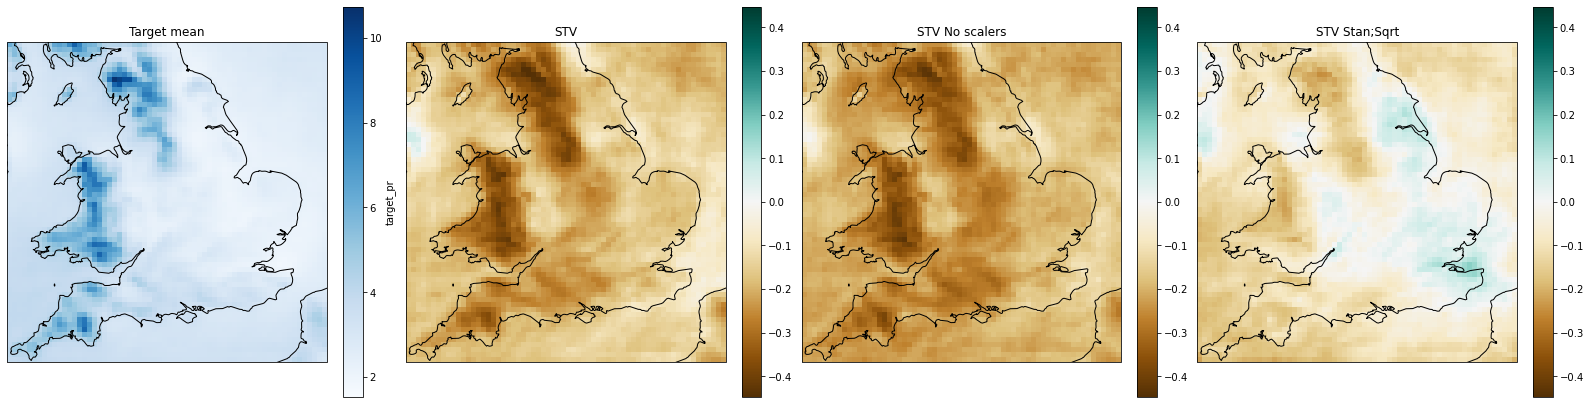

Season JJA

CPM

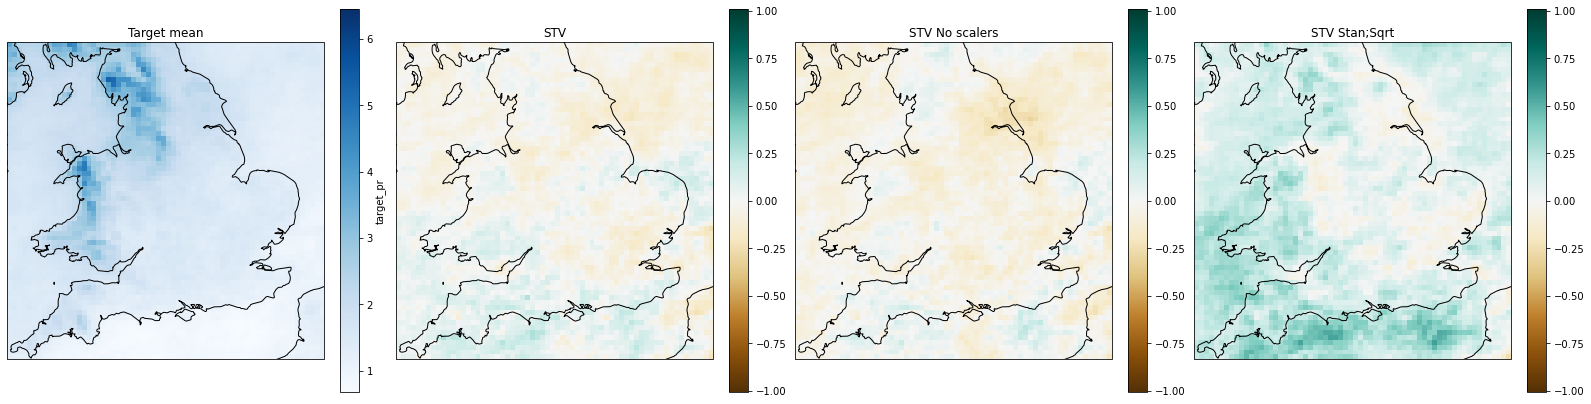

GCM

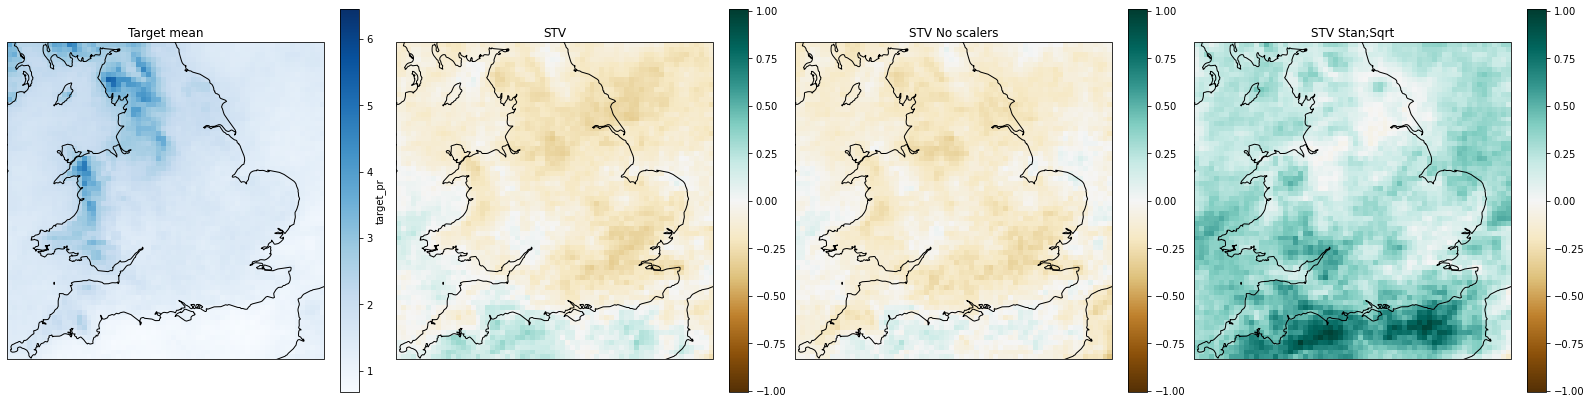

Season MAM

CPM

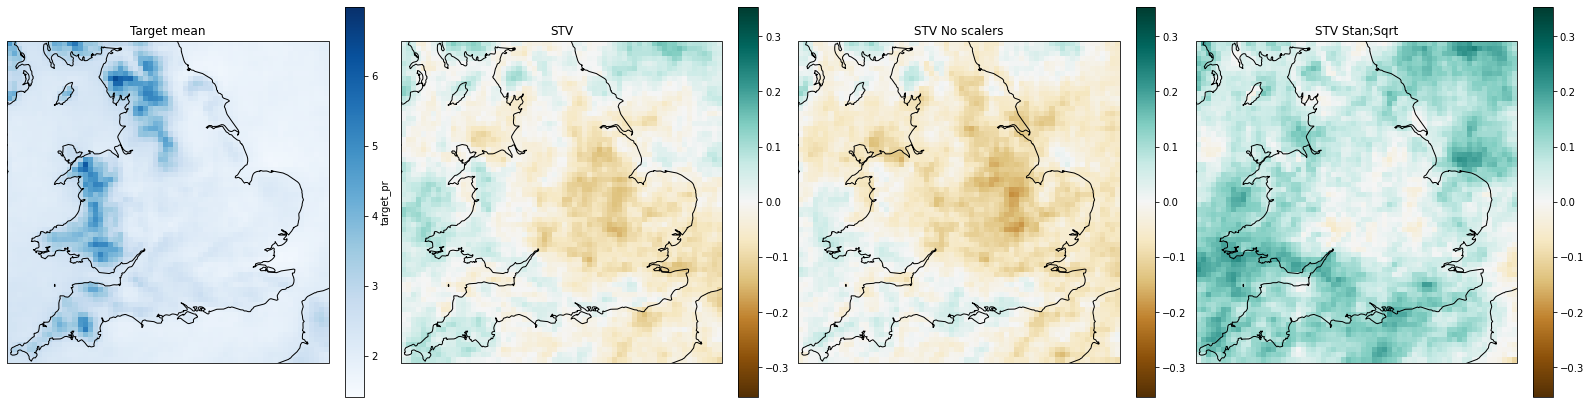

GCM

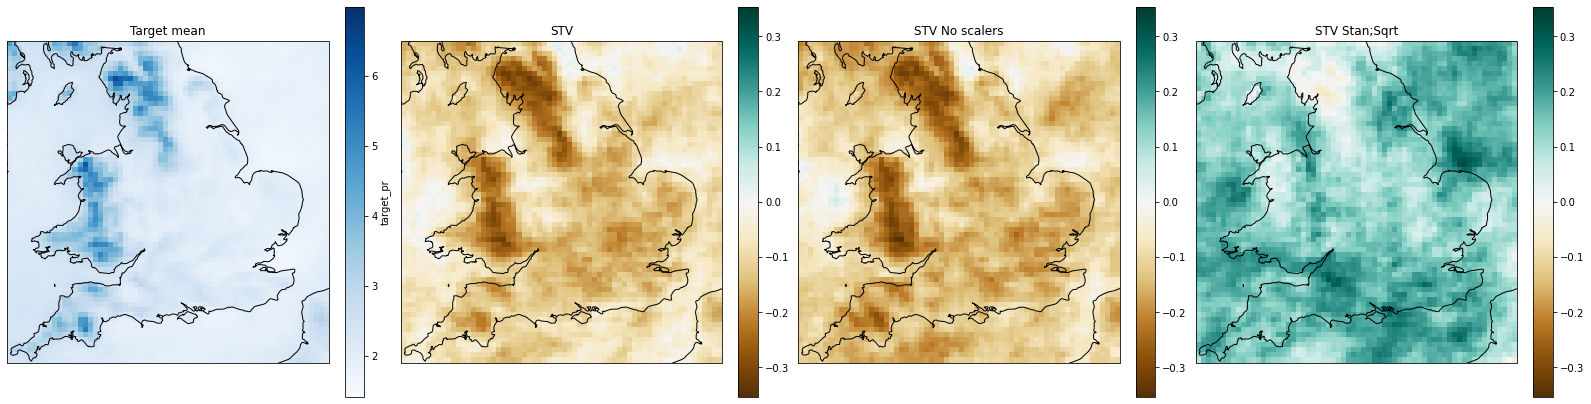

Season SON

CPM

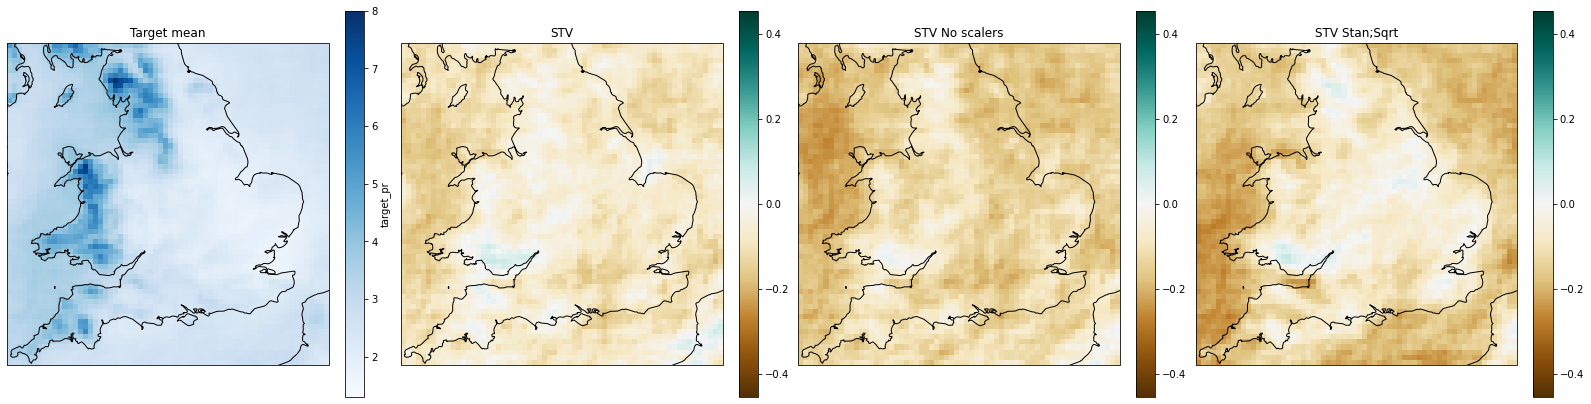

GCM

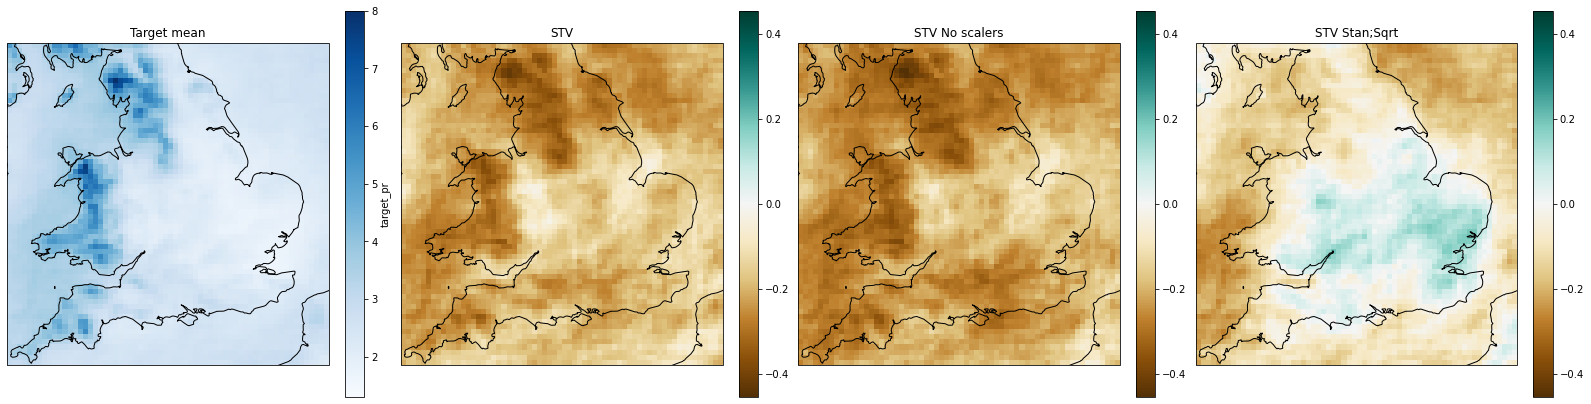

In [9]:
plot_mean_bias(merged_ds)

## Standard deviation

CPM

STV

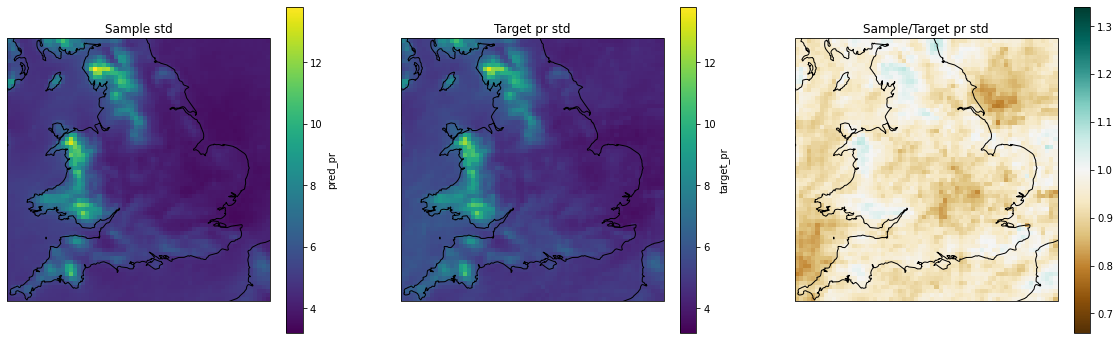

STV No scalers

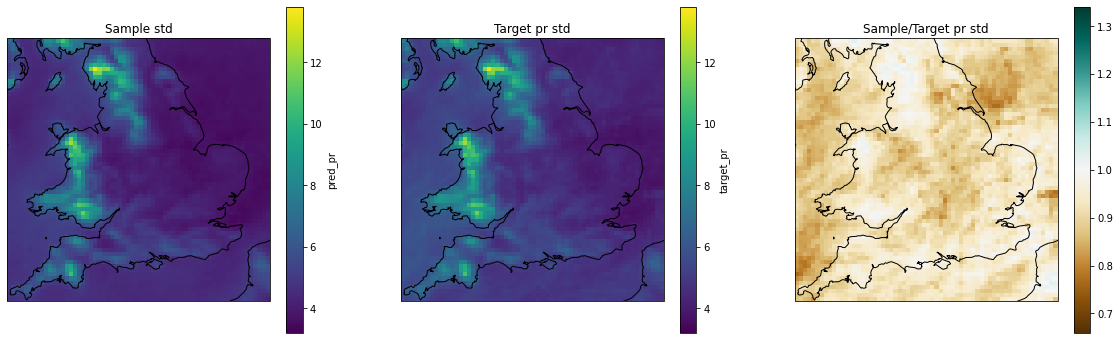

STV Stan;Sqrt

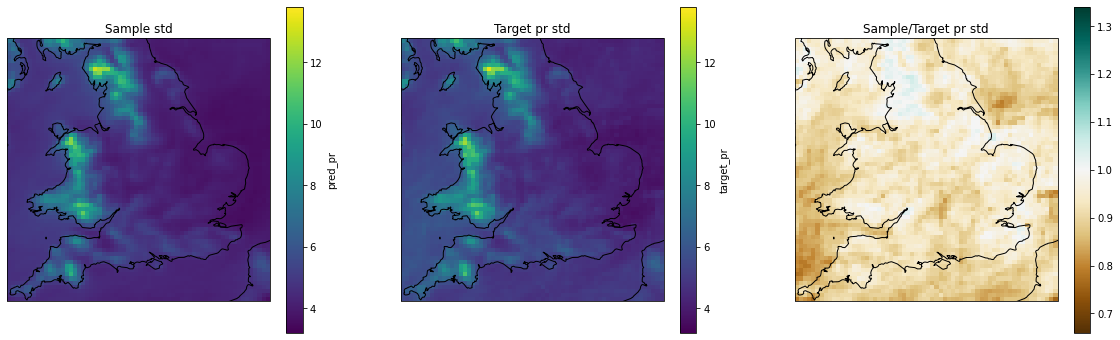

GCM

STV

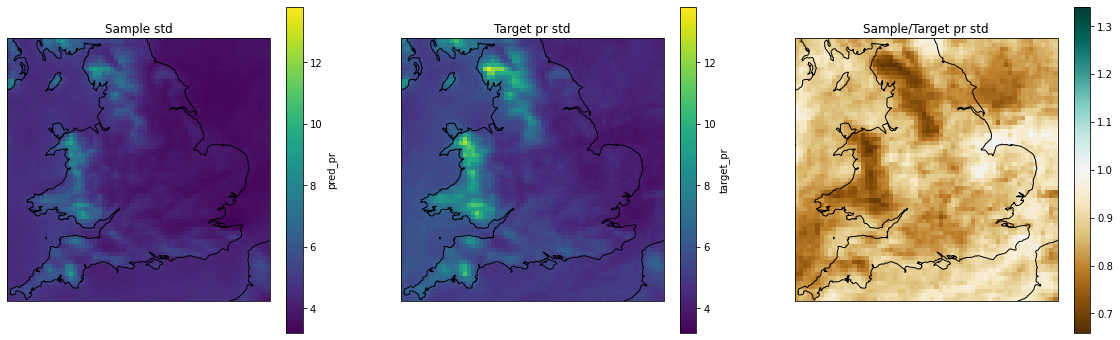

STV No scalers

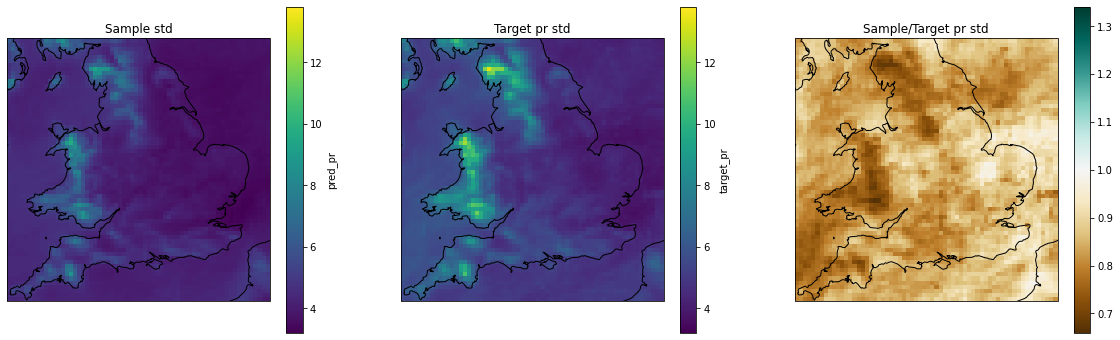

STV Stan;Sqrt

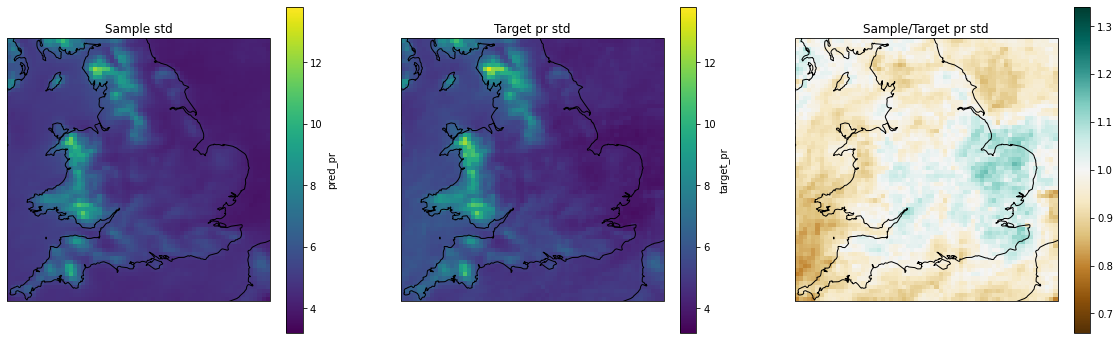

In [10]:
plot_std(merged_ds)

## Scatter

In [11]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


# ax = axs

# ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')


In [12]:
# sample_ids = np.arange(9).reshape(3, 3)

# fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

# for i, sample_id in enumerate(sample_ids.flatten()):
#     ax = axs[i//3][i%3]

#     ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
#     ax.plot([0, tr], [0, tr], linewidth=1, color='green')
#     ax.set_xlabel(f"Sample {sample_id} pr")
#     ax.set_ylabel(f"Target pr")
    
# plt.show()

In [13]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(total_pred_pr.max(), total_target_pr.max())

# ax = axs

# ax.scatter(x=total_pred_pr, y=total_target_pr.values[None, :].repeat(len(total_pred_pr["sample_id"]), 0), alpha=0.25)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')

# plt.show()

## PSD

## Correlation